<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/GRU_reviewtokobaju.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen Review Toko Baju menggunakan (GRU)

Notebook ini berisi implementasi model Gated Recurrent Unit (GRU) untuk analisis sentimen pada dataset ReviewTokoBaju.csv. Model akan mengklasifikasikan ulasan ke dalam sentimen positif atau negatif berdasarkan teks ulasan.

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import re
import string
from collections import Counter
from tqdm.notebook import tqdm
import nltk
from nltk.corpus import stopwords

# Download resources untuk preprocessing
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## 1. Persiapan Lingkungan

Mengatur seed untuk reproducibility dan mengecek ketersediaan GPU untuk mempercepat training.

In [2]:
# Set seed untuk reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Cek ketersediaan GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

# Cek GPU di Google Colab
try:
    !nvidia-smi
except:
    print("Tidak dapat mengakses nvidia-smi, kemungkinan tidak ada GPU")

Menggunakan device: cpu
/bin/bash: line 1: nvidia-smi: command not found


## 2. Membaca dan Menjelajahi Dataset

Kita akan membaca dataset, membersihkan data, dan mengeksplorasi distribusi label sentimen.

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ReviewTokoBaju.csv to ReviewTokoBaju.csv


Ukuran dataset: (23486, 11)
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        In

<ipython-input-5-ac375c7e81d7>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette='viridis')


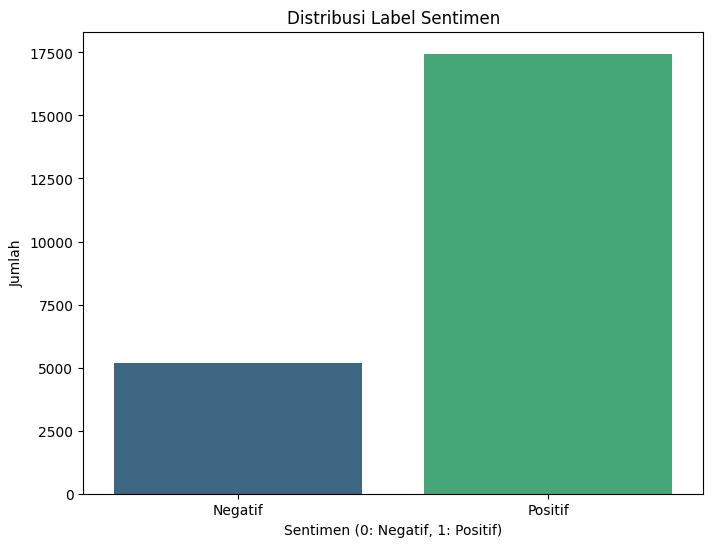

In [5]:
# Membaca dataset
df = pd.read_csv('ReviewTokoBaju.csv')
print(f"Ukuran dataset: {df.shape}")
print(df.head())

# Membersihkan dataset
# Memfilter data yang memiliki 'Review Text' dan 'Rating'
df = df.dropna(subset=['Review Text', 'Rating'])

# Membuat kolom sentimen berdasarkan Rating (4-5 positif, 1-3 negatif)
df['sentiment'] = df['Rating'].apply(lambda x: 1 if float(x) >= 4 else 0)

# Melihat distribusi label sentimen
print("\nDistribusi sentimen:")
print(df['sentiment'].value_counts())
print(f"Persentase positif: {df['sentiment'].mean()*100:.2f}%")

# Visualisasi distribusi sentimen
plt.figure(figsize=(8, 6))
sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Distribusi Label Sentimen')
plt.xlabel('Sentimen (0: Negatif, 1: Positif)')
plt.ylabel('Jumlah')
plt.xticks([0, 1], ['Negatif', 'Positif'])
plt.show()

## 3. Preprocessing Teks

Kita akan melakukan preprocessing pada teks ulasan, yang meliputi:
- Konversi ke lowercase
- Menghapus tanda baca
- Menghapus angka
- Menghapus spasi berlebih
- Menghapus stopwords

In [6]:
# Fungsi untuk preprocessing teks
def preprocess_text(text):
    # Konversi ke lowercase
    text = str(text).lower()

    # Hapus tanda baca
    text = re.sub(f'[{string.punctuation}]', ' ', text)

    # Hapus angka
    text = re.sub(r'\d+', '', text)

    # Hapus spasi berlebih
    text = re.sub(r'\s+', ' ', text).strip()

    # Hapus stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]

    return ' '.join(words)

# Terapkan preprocessing
df['cleaned_text'] = df['Review Text'].apply(preprocess_text)

# Melihat contoh hasil preprocessing
print("\nContoh teks asli dan hasil preprocessing:")
for i in range(3):
    print(f"Original: {df['Review Text'].iloc[i][:100]}...")
    print(f"Cleaned: {df['cleaned_text'].iloc[i][:100]}...")
    print()


Contoh teks asli dan hasil preprocessing:
Original: Absolutely wonderful - silky and sexy and comfortable...
Cleaned: absolutely wonderful silky sexy comfortable...

Original: Love this dress!  it's sooo pretty.  i happened to find it in a store, and i'm glad i did bc i never...
Cleaned: love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petit...

Original: I had such high hopes for this dress and really wanted it to work for me. i initially ordered the pe...
Cleaned: high hopes dress really wanted work initially ordered petite small usual size found outrageously sma...



## 4. Split Data menjadi Training dan Testing Set

Kita akan membagi dataset menjadi training set (80%) dan testing set (20%) dengan mempertahankan distribusi kelas yang sama menggunakan stratified split.

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['cleaned_text'],
    df['sentiment'],
    test_size=0.2,
    random_state=SEED,
    stratify=df['sentiment']
)

print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

# Cek distribusi label pada training dan testing set
print(f"Distribusi label training: {y_train.value_counts() / len(y_train)}")
print(f"Distribusi label testing: {y_test.value_counts() / len(y_test)}")

Jumlah data training: 18112
Jumlah data testing: 4529
Distribusi label training: sentiment
1    0.770649
0    0.229351
Name: count, dtype: float64
Distribusi label testing: sentiment
1    0.77059
0    0.22941
Name: count, dtype: float64


## 5. Membangun Vocabulary dan Tokenisasi

Kita akan membuat vocabulary dari dataset training dan fungsi untuk mengubah teks menjadi sequence angka.

In [8]:
# Buat vocabulary
def build_vocab(texts, max_vocab_size=10000):
    counter = Counter()
    for text in texts:
        counter.update(text.split())

    # Ambil kata-kata yang paling sering muncul
    most_common = counter.most_common(max_vocab_size - 2)  # -2 untuk <PAD> dan <UNK>
    vocab = {'<PAD>': 0, '<UNK>': 1}
    vocab.update({word: idx + 2 for idx, (word, _) in enumerate(most_common)})

    return vocab

vocab = build_vocab(X_train)
print(f"Ukuran vocabulary: {len(vocab)}")
print(f"10 kata paling umum: {list(vocab.items())[2:12]}")  # Skip <PAD> dan <UNK>

# Fungsi untuk mengubah teks menjadi sequence
def text_to_sequence(text, vocab, max_length=100):
    words = text.split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words]

    # Potong atau padding sesuai max_length
    if len(sequence) > max_length:
        sequence = sequence[:max_length]
    else:
        sequence = sequence + [vocab['<PAD>']] * (max_length - len(sequence))

    return sequence

# Melihat hasil tokenisasi
sample_text = X_train.iloc[0]
sample_seq = text_to_sequence(sample_text, vocab)
print(f"Teks asli: {sample_text[:50]}...")
print(f"Sequence: {sample_seq[:20]}...")

Ukuran vocabulary: 10000
10 kata paling umum: [('dress', 2), ('love', 3), ('size', 4), ('top', 5), ('fit', 6), ('like', 7), ('wear', 8), ('great', 9), ('would', 10), ('fabric', 11)]
Teks asli: love shirt lbs normally pxs got pxxs got perfect n...
Sequence: [3, 33, 58, 158, 1604, 40, 4177, 40, 17, 342, 253, 33, 0, 0, 0, 0, 0, 0, 0, 0]...


## 6. Membuat Dataset dan DataLoader PyTorch

Kita akan membuat custom Dataset dan DataLoader untuk PyTorch yang akan digunakan selama training.

In [9]:
# Buat dataset PyTorch
class ReviewDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_length=100):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]

        # Konversi text ke sequence
        sequence = text_to_sequence(text, self.vocab, self.max_length)

        return {
            'text': torch.tensor(sequence, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameter dataset
MAX_LENGTH = 100
BATCH_SIZE = 64

# Buat dataset dan dataloader
train_dataset = ReviewDataset(X_train, y_train, vocab, MAX_LENGTH)
test_dataset = ReviewDataset(X_test, y_test, vocab, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Cek bentuk batch
sample_batch = next(iter(train_loader))
print(f"Bentuk batch teks: {sample_batch['text'].shape}")
print(f"Bentuk batch label: {sample_batch['label'].shape}")

Bentuk batch teks: torch.Size([64, 100])
Bentuk batch label: torch.Size([64])


## 7. Definisi Model GRU

Kita akan mendefinisikan arsitektur model GRU untuk analisis sentimen. Model ini terdiri dari:
- Embedding layer
- Bidirectional GRU layers
- Dropout untuk regularisasi
- Fully connected layer untuk output

In [10]:
# Definisi model GRU
class GRUSentimentModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers=2, bidirectional=True, dropout=0.5):
        super().__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # GRU layer
        self.gru = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text shape: [batch size, sentence length]

        # embedded shape: [batch size, sentence length, embedding dim]
        embedded = self.embedding(text)

        # output shape: [batch size, sentence length, hidden dim * num directions]
        # hidden shape: [num layers * num directions, batch size, hidden dim]
        output, hidden = self.gru(embedded)

        if self.gru.bidirectional:
            # Concat the final forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]

        # Apply dropout
        hidden = self.dropout(hidden)

        # Final linear layer
        return self.fc(hidden)

## 8. Inisialisasi Model dan Optimizer

Kita akan menginisialisasi model dengan hyperparameter yang telah ditentukan dan menyiapkan loss function serta optimizer.

In [11]:
# Hyperparameter model
INPUT_DIM = len(vocab)  # ukuran vocabulary
EMBEDDING_DIM = 100     # dimensi embedding
HIDDEN_DIM = 256        # dimensi hidden state
OUTPUT_DIM = 1          # dimensi output (binary classification)
N_LAYERS = 2            # jumlah layer GRU
BIDIRECTIONAL = True    # GRU bidirectional
DROPOUT = 0.5           # dropout rate
LEARNING_RATE = 0.001   # learning rate
N_EPOCHS = 10           # jumlah epoch

# Instantiate model
model = GRUSentimentModel(
    INPUT_DIM,
    EMBEDDING_DIM,
    HIDDEN_DIM,
    OUTPUT_DIM,
    N_LAYERS,
    BIDIRECTIONAL,
    DROPOUT
).to(device)

# Tampilkan ringkasan model (jumlah parameter)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Model memiliki {count_parameters(model):,} parameter yang dapat dilatih')

# Binary cross entropy loss dan Adam optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Model memiliki 2,733,121 parameter yang dapat dilatih


## 9. Fungsi untuk Training dan Evaluasi

Kita akan mendefinisikan fungsi-fungsi helper untuk melatih model dan mengevaluasi performa pada dataset testing.

In [12]:
# Fungsi untuk menghitung akurasi
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Fungsi untuk training
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="Training"):
        # Reset gradients
        optimizer.zero_grad()

        # Get data
        text = batch['text'].to(device)
        labels = batch['label'].float().to(device)

        # Forward pass
        predictions = model(text).squeeze(1)

        # Compute loss
        loss = criterion(predictions, labels)

        # Compute accuracy
        acc = binary_accuracy(predictions, labels)

        # Backward pass
        loss.backward()

        # Update parameters
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Fungsi untuk evaluasi
def evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0

    all_preds = []
    all_labels = []

    model.eval()

    with torch.no_grad():
        for batch in tqdm(iterator, desc="Evaluating"):
            # Get data
            text = batch['text'].to(device)
            labels = batch['label'].float().to(device)

            # Forward pass
            predictions = model(text).squeeze(1)

            # Save predictions and labels
            all_preds.extend(torch.sigmoid(predictions).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Compute loss
            loss = criterion(predictions, labels)

            # Compute accuracy
            acc = binary_accuracy(predictions, labels)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), np.array(all_preds), np.array(all_labels)

## 10. Training Loop

Kita akan melatih model untuk beberapa epoch, menyimpan model terbaik berdasarkan akurasi testing, dan memvisualisasikan training progress.

In [13]:
# Training loop
train_losses = []
train_accs = []
test_losses = []
test_accs = []

best_test_acc = 0

for epoch in range(N_EPOCHS):
    # Training
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Evaluation
    test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Save best model
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        torch.save(model.state_dict(), 'best_gru_model.pt')

    print(f'Epoch: {epoch+1:02}')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tTest Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 01
	Train Loss: 0.427 | Train Acc: 80.95%
	Test Loss: 0.360 | Test Acc: 83.67%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 02
	Train Loss: 0.311 | Train Acc: 86.72%
	Test Loss: 0.356 | Test Acc: 86.34%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 03
	Train Loss: 0.257 | Train Acc: 89.34%
	Test Loss: 0.312 | Test Acc: 86.10%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 04
	Train Loss: 0.211 | Train Acc: 91.35%
	Test Loss: 0.319 | Test Acc: 86.61%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 05
	Train Loss: 0.158 | Train Acc: 93.87%
	Test Loss: 0.348 | Test Acc: 86.40%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 06
	Train Loss: 0.108 | Train Acc: 95.96%
	Test Loss: 0.433 | Test Acc: 86.38%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 07
	Train Loss: 0.067 | Train Acc: 97.69%
	Test Loss: 0.540 | Test Acc: 85.54%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 08
	Train Loss: 0.050 | Train Acc: 98.25%
	Test Loss: 0.584 | Test Acc: 85.86%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 09
	Train Loss: 0.032 | Train Acc: 98.99%
	Test Loss: 0.684 | Test Acc: 85.16%


Training:   0%|          | 0/283 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Epoch: 10
	Train Loss: 0.026 | Train Acc: 99.22%
	Test Loss: 0.664 | Test Acc: 85.89%


## 11. Evaluasi Model dengan Metrik Lengkap

Kita akan mengevaluasi model terbaik menggunakan berbagai metrik evaluasi (akurasi, presisi, recall, f1-score, AUC-ROC, dll.).

In [21]:
# Load best model
model.load_state_dict(torch.load('best_gru_model.pt'))

# Evaluasi dengan semua metrik
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

# Binarize predictions
test_preds_binary = np.round(test_preds)

# Evaluasi metrik
accuracy = accuracy_score(test_labels, test_preds_binary)
precision = precision_score(test_labels, test_preds_binary)
recall = recall_score(test_labels, test_preds_binary)
f1 = f1_score(test_labels, test_preds_binary)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

# Print classification report
print("\nClassification Report:")
print(classification_report(test_labels, test_preds_binary))

Evaluating:   0%|          | 0/71 [00:00<?, ?it/s]

Test Loss: 0.319 | Test Acc: 86.61%
Accuracy: 0.8660
Precision: 0.9179
Recall: 0.9072
F1 Score: 0.9125

Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.73      0.71      1039
         1.0       0.92      0.91      0.91      3490

    accuracy                           0.87      4529
   macro avg       0.81      0.82      0.81      4529
weighted avg       0.87      0.87      0.87      4529



## 12. Visualisasi Hasil

Kita akan memvisualisasikan hasil evaluasi model dengan confusion matrix, ROC curve, dan training history.

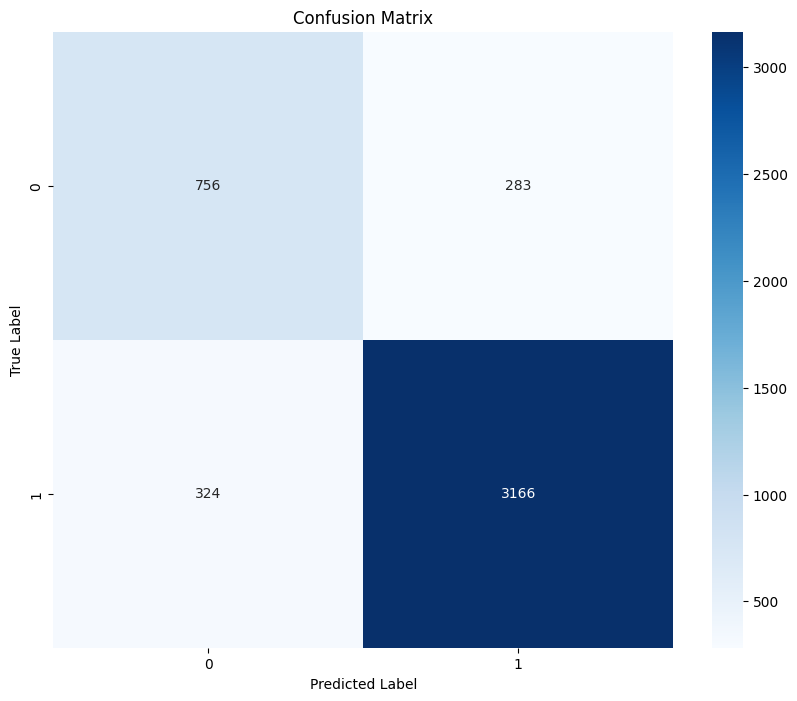

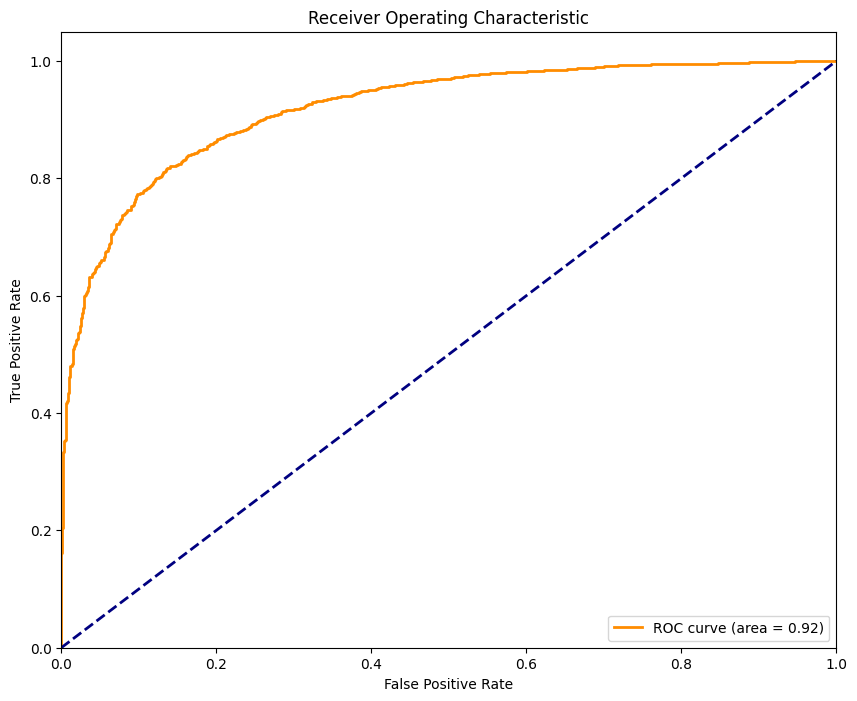

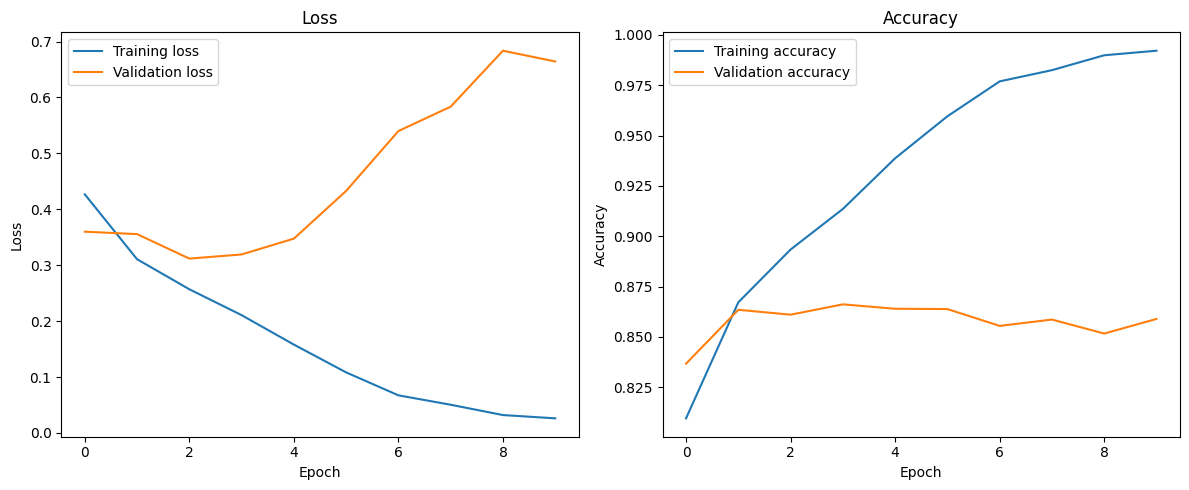

In [22]:
# Visualisasi confusion matr
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_labels, test_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix_gru.png')
plt.show()

# ROC Curve dan AUC
fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.savefig('roc_curve_gru.png')
plt.show()

# Plotting training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Validation accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history_gru.png')
plt.show()

## 13. Fungsi untuk Prediksi Review Baru

Kita akan membuat fungsi untuk memprediksi sentimen pada review baru.

In [19]:
# Fungsi untuk prediksi review baru
def predict_sentiment(model, text, vocab, max_length=100):
    model.eval()

    # Preprocess text
    processed_text = preprocess_text(text)

    # Convert to sequence
    sequence = text_to_sequence(processed_text, vocab, max_length)
    sequence_tensor = torch.tensor(sequence).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        prediction = torch.sigmoid(model(sequence_tensor).squeeze())

    # Return sentiment and probability
    sentiment = "Positif" if prediction.item() >= 0.5 else "Negatif"
    probability = prediction.item() if sentiment == "Positif" else 1 - prediction.item()

    return {
        "text": text,
        "sentiment": sentiment,
        "probability": probability
    }

# Contoh penggunaan
review_examples = [
    "Saya sangat senang dengan baju ini, kualitasnya sangat bagus!",
    "Kecewa dengan produk ini, ukurannya tidak sesuai dan kainnya tipis."
]

for review in review_examples:
    result = predict_sentiment(model, review, vocab)
    print(f"Review: {result['text']}")
    print(f"Sentimen: {result['sentiment']} (Probabilitas: {result['probability']:.4f})")
    print()

Review: Saya sangat senang dengan baju ini, kualitasnya sangat bagus!
Sentimen: Positif (Probabilitas: 0.7749)

Review: Kecewa dengan produk ini, ukurannya tidak sesuai dan kainnya tipis.
Sentimen: Positif (Probabilitas: 0.7815)



## 14. Analisis Error

Kita akan mengidentifikasi dan menganalisis beberapa contoh yang salah diprediksi oleh model.

In [20]:
# Analisis kesalahan prediksi
# Identifikasi contoh-contoh yang salah diprediksi
misclassified_indices = np.where(test_preds_binary != test_labels)[0]
print(f"Jumlah contoh yang salah diklasifikasikan: {len(misclassified_indices)} dari {len(test_labels)}")

# Ambil beberapa contoh misklasifikasi
n_examples = min(5, len(misclassified_indices))
for idx in misclassified_indices[:n_examples]:
    text = X_test.iloc[idx]
    true_label = "Positif" if test_labels[idx] == 1 else "Negatif"
    pred_label = "Positif" if test_preds_binary[idx] == 1 else "Negatif"
    prob = test_preds[idx] if pred_label == "Positif" else 1 - test_preds[idx]

    print(f"Review: {text[:100]}...")
    print(f"Label Sebenarnya: {true_label}")
    print(f"Label Prediksi: {pred_label} (Probabilitas: {prob:.4f})")
    print()

Jumlah contoh yang salah diklasifikasikan: 607 dari 4529
Review: well made well designed tunic top looks great pants recommended tucking pin tucks hit right waistlin...
Label Sebenarnya: Positif
Label Prediksi: Negatif (Probabilitas: 0.8846)

Review: nice sweater return came late birthday gift giving also sweater originally thought ordered mistake s...
Label Sebenarnya: Positif
Label Prediksi: Negatif (Probabilitas: 0.7124)

Review: sweater super cute wish worked must like sweaters little longer everyone else hit wrong place still ...
Label Sebenarnya: Positif
Label Prediksi: Negatif (Probabilitas: 0.7399)

Review: saw dress store immediately grabbed think seen online looked twice person fabric beautiful shining c...
Label Sebenarnya: Positif
Label Prediksi: Negatif (Probabilitas: 0.9239)

Review: normally wear large give bust beware big chested girls...
Label Sebenarnya: Positif
Label Prediksi: Negatif (Probabilitas: 0.9491)



## 15. Perbandingan Model GRU vs LSTM

Jika Anda telah menjalankan notebook LSTM sebelumnya, kita dapat membandingkan performa keduanya.

In [18]:
# Perbandingan performa GRU vs LSTM
# Asumsikan kita telah menyimpan metrik LSTM sebelumnya di variabel lstm_metrics
# Jika tidak, komentar bagian ini

try:
    # Coba membaca metrik LSTM dari file (jika ada)
    lstm_metrics = pd.read_csv('lstm_metrics.csv')

    # Buat dataframe untuk metrik GRU
    gru_metrics = pd.DataFrame({
        'Model': ['GRU'],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1_Score': [f1],
        'AUC': [roc_auc]
    })

    # Gabungkan kedua dataframe
    comparison_df = pd.concat([lstm_metrics, gru_metrics])

    # Visualisasi perbandingan
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score', 'AUC']

    plt.figure(figsize=(12, 6))

    # Plot untuk setiap metrik
    bar_width = 0.35
    index = np.arange(len(metrics))

    plt.bar(index, comparison_df[comparison_df['Model'] == 'LSTM'][metrics].values[0],
            bar_width, label='LSTM', color='skyblue')

    plt.bar(index + bar_width, comparison_df[comparison_df['Model'] == 'GRU'][metrics].values[0],
            bar_width, label='GRU', color='lightcoral')

    plt.xlabel('Metrik')
    plt.ylabel('Nilai')
    plt.title('Perbandingan Performa LSTM vs GRU')
    plt.xticks(index + bar_width / 2, metrics)
    plt.legend()

    plt.tight_layout()
    plt.savefig('lstm_vs_gru_comparison.png')
    plt.show()

except:
    print("File metrik LSTM tidak ditemukan atau terjadi kesalahan saat membandingkan.")

    # Simpan metrik GRU untuk perbandingan di masa depan
    gru_metrics = pd.DataFrame({
        'Model': ['GRU'],
        'Accuracy': [accuracy],
        'Precision': [precision],
        'Recall': [recall],
        'F1_Score': [f1],
        'AUC': [roc_auc]
    })

    gru_metrics.to_csv('gru_metrics.csv', index=False)
    print("Metrik GRU telah disimpan untuk perbandingan di masa depan.")

File metrik LSTM tidak ditemukan atau terjadi kesalahan saat membandingkan.
Metrik GRU telah disimpan untuk perbandingan di masa depan.


# Penjelasan Matematis Model GRU untuk Analisis Sentimen

GRU (Gated Recurrent Unit) adalah variasi dari RNN yang dikembangkan untuk mengatasi masalah vanishing gradient pada RNN tradisional, serupa dengan LSTM tetapi dengan arsitektur yang lebih sederhana.

## 1. Word Embedding

Word embedding mengkonversi kata (yang direpresentasikan sebagai indeks diskrit) menjadi vektor dense berdimensi rendah.

$$e_i = W_e \cdot x_i$$

di mana:
- $e_i \in \mathbb{R}^d$ adalah vektor embedding untuk kata ke-$i$
- $W_e \in \mathbb{R}^{|V| \times d}$ adalah matriks embedding, dengan $|V|$ adalah ukuran vocabulary dan $d$ adalah dimensi embedding
- $x_i \in \mathbb{R}^{|V|}$ adalah representasi one-hot encoding dari kata ke-$i$

## 2. GRU (Gated Recurrent Unit)

GRU memiliki dua gerbang: update gate dan reset gate.

### a. Update Gate

Update gate menentukan seberapa banyak informasi sebelumnya yang akan dipertahankan.

$$z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)$$

di mana:
- $z_t \in \mathbb{R}^h$ adalah vektor update gate pada waktu $t$
- $\sigma$ adalah fungsi sigmoid: $\sigma(z) = \frac{1}{1+e^{-z}}$
- $W_z \in \mathbb{R}^{h \times (h+d)}$ adalah matriks bobot untuk update gate
- $h_{t-1} \in \mathbb{R}^h$ adalah hidden state sebelumnya
- $x_t \in \mathbb{R}^d$ adalah input pada waktu $t$
- $b_z \in \mathbb{R}^h$ adalah vektor bias untuk update gate
- $[h_{t-1}, x_t]$ menunjukkan konkatenasi vektor $h_{t-1}$ dan $x_t$

### b. Reset Gate

Reset gate menentukan seberapa banyak informasi sebelumnya yang akan dilupakan.

$$r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)$$

di mana:
- $r_t \in \mathbb{R}^h$ adalah vektor reset gate pada waktu $t$
- $W_r \in \mathbb{R}^{h \times (h+d)}$ adalah matriks bobot untuk reset gate
- $b_r \in \mathbb{R}^h$ adalah vektor bias untuk reset gate

### c. Candidate Hidden State

Kandidat hidden state dihitung dengan mempertimbangkan reset gate.

$$\tilde{h}_t = \tanh(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)$$

di mana:
- $\tilde{h}_t \in \mathbb{R}^h$ adalah kandidat hidden state pada waktu $t$
- $\tanh$ adalah fungsi hyperbolic tangent: $\tanh(z) = \frac{e^z - e^{-z}}{e^z + e^{-z}}$
- $W_h \in \mathbb{R}^{h \times (h+d)}$ adalah matriks bobot
- $\odot$ adalah perkalian element-wise (Hadamard product)
- $b_h \in \mathbb{R}^h$ adalah vektor bias

### d. Final Hidden State

Hidden state akhir dihitung sebagai kombinasi linear dari hidden state sebelumnya dan kandidat hidden state, dikontrol oleh update gate.

$$h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde{h}_t$$

di mana:
- $h_t \in \mathbb{R}^h$ adalah hidden state pada waktu $t$
- $(1 - z_t) \odot h_{t-1}$ mengontrol berapa banyak informasi sebelumnya yang dipertahankan
- $z_t \odot \tilde{h}_t$ mengontrol berapa banyak informasi baru yang ditambahkan

## 3. Bidirectional GRU

Bidirectional GRU menjalankan dua GRU secara terpisah:
1. Forward GRU: memproses sequence dari awal hingga akhir
2. Backward GRU: memproses sequence dari akhir hingga awal

Hidden state terakhir dari kedua GRU kemudian digabungkan:

$$h_{final} = [h_{forward}, h_{backward}]$$

di mana:
- $h_{forward} \in \mathbb{R}^h$ adalah hidden state terakhir dari forward GRU
- $h_{backward} \in \mathbb{R}^h$ adalah hidden state terakhir dari backward GRU
- $h_{final} \in \mathbb{R}^{2h}$ adalah gabungan hidden state yang akan digunakan sebagai representasi sequence

## 4. Fully Connected Layer

Fully connected layer mengkonversi representasi sequence menjadi skor prediksi:

$$z = W_{fc} \cdot h_{final} + b_{fc}$$

di mana:
- $z \in \mathbb{R}$ adalah skor logit untuk klasifikasi biner
- $W_{fc} \in \mathbb{R}^{1 \times 2h}$ adalah matriks bobot
- $b_{fc} \in \mathbb{R}$ adalah bias

## 5. Fungsi Aktivasi Sigmoid

Untuk klasifikasi biner, skor logit dikonversi menjadi probabilitas menggunakan fungsi sigmoid:

$$\hat{y} = \sigma(z) = \frac{1}{1 + e^{-z}}$$

di mana:
- $\hat{y} \in [0,1]$ adalah probabilitas prediksi untuk kelas positif

## 6. Binary Cross-Entropy Loss

Loss function untuk klasifikasi biner adalah Binary Cross-Entropy:

$$\mathcal{L}(y, \hat{y}) = -\frac{1}{N} \sum_{i=1}^{N} [y_i \log(\hat{y}_i) + (1-y_i) \log(1-\hat{y}_i)]$$

di mana:
- $y_i \in \{0,1\}$ adalah label sebenarnya untuk contoh ke-$i$
- $\hat{y}_i \in [0,1]$ adalah probabilitas prediksi untuk contoh ke-$i$
- $N$ adalah jumlah contoh dalam batch

## 7. Metrik Evaluasi

### a. Akurasi
$$\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$

### b. Presisi
$$\text{Precision} = \frac{TP}{TP + FP}$$

### c. Recall
$$\text{Recall} = \frac{TP}{TP + FN}$$

### d. F1 Score
$$\text{F1} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}$$

### e. Area Under ROC Curve (AUC)
AUC menghitung area di bawah kurva ROC, yang menunjukkan kemampuan model untuk membedakan kelas.

$$\text{AUC} = \int_{0}^{1} TPR(FPR^{-1}(x)) \, dx$$

di mana:
- TPR (True Positive Rate) = Recall = $\frac{TP}{TP + FN}$
- FPR (False Positive Rate) = $\frac{FP}{FP + TN}$

## 17. Perbedaan Utama Antara GRU dan LSTM

GRU (Gated Recurrent Unit) dan LSTM (Long Short-Term Memory) adalah dua variasi populer dari RNN yang didesain untuk mengatasi masalah vanishing gradient. Berikut perbedaan utama antara keduanya:

### Arsitektur
- **GRU**: Memiliki arsitektur yang lebih sederhana dengan dua gerbang (update gate dan reset gate)
- **LSTM**: Memiliki arsitektur yang lebih kompleks dengan tiga gerbang (forget gate, input gate, output gate) dan cell state terpisah

### Performa
- **GRU**: Lebih ringan secara komputasi dan membutuhkan memori lebih sedikit
- **LSTM**: Lebih powerful untuk sequence yang sangat panjang dan kompleks

### Gerbang Kontrol
- **GRU**: Menggunakan reset gate untuk mengontrol informasi yang akan dilupakan dan update gate untuk mengontrol informasi baru
- **LSTM**: Menggunakan forget gate untuk menghapus informasi, input gate untuk menambah informasi baru, dan output gate untuk mengontrol output

### Cell State
- **GRU**: Tidak memiliki cell state terpisah, hanya hidden state
- **LSTM**: Memiliki cell state terpisah yang didesain khusus untuk menyimpan informasi jangka panjang

### Kecepatan Training
- **GRU**: Biasanya lebih cepat karena memiliki parameter lebih sedikit
- **LSTM**: Cenderung lebih lambat karena arsitektur yang lebih kompleks

### Aplikasi
- **GRU**: Cocok untuk dataset kecil hingga menengah dan resource komputasi terbatas
- **LSTM**: Lebih cocok untuk dataset besar dan masalah yang kompleks